In [1]:
# Data processing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Mathematical operations
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Split the data
from sklearn.model_selection import train_test_split
# Data scaling (standardization)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
# Performance Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Neglate warnings
import warnings
warnings.filterwarnings("ignore")
# modelling
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
# data balancing
from sklearn.utils import class_weight



In [2]:
diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
diabetes_data.shape

(768, 9)

In [4]:
diabetes_data_col_idx = diabetes_data.columns
diabetes_data_col_idx

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
diabetes_data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
diabetes_data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

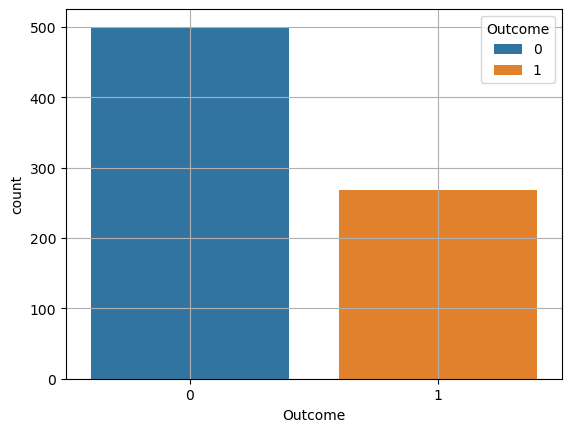

In [7]:
sns.countplot(x = 'Outcome', data = diabetes_data, hue = 'Outcome')
plt.grid()
# class 0 and 1 are imbalanced so usage of class weights technique can make class to be balanced

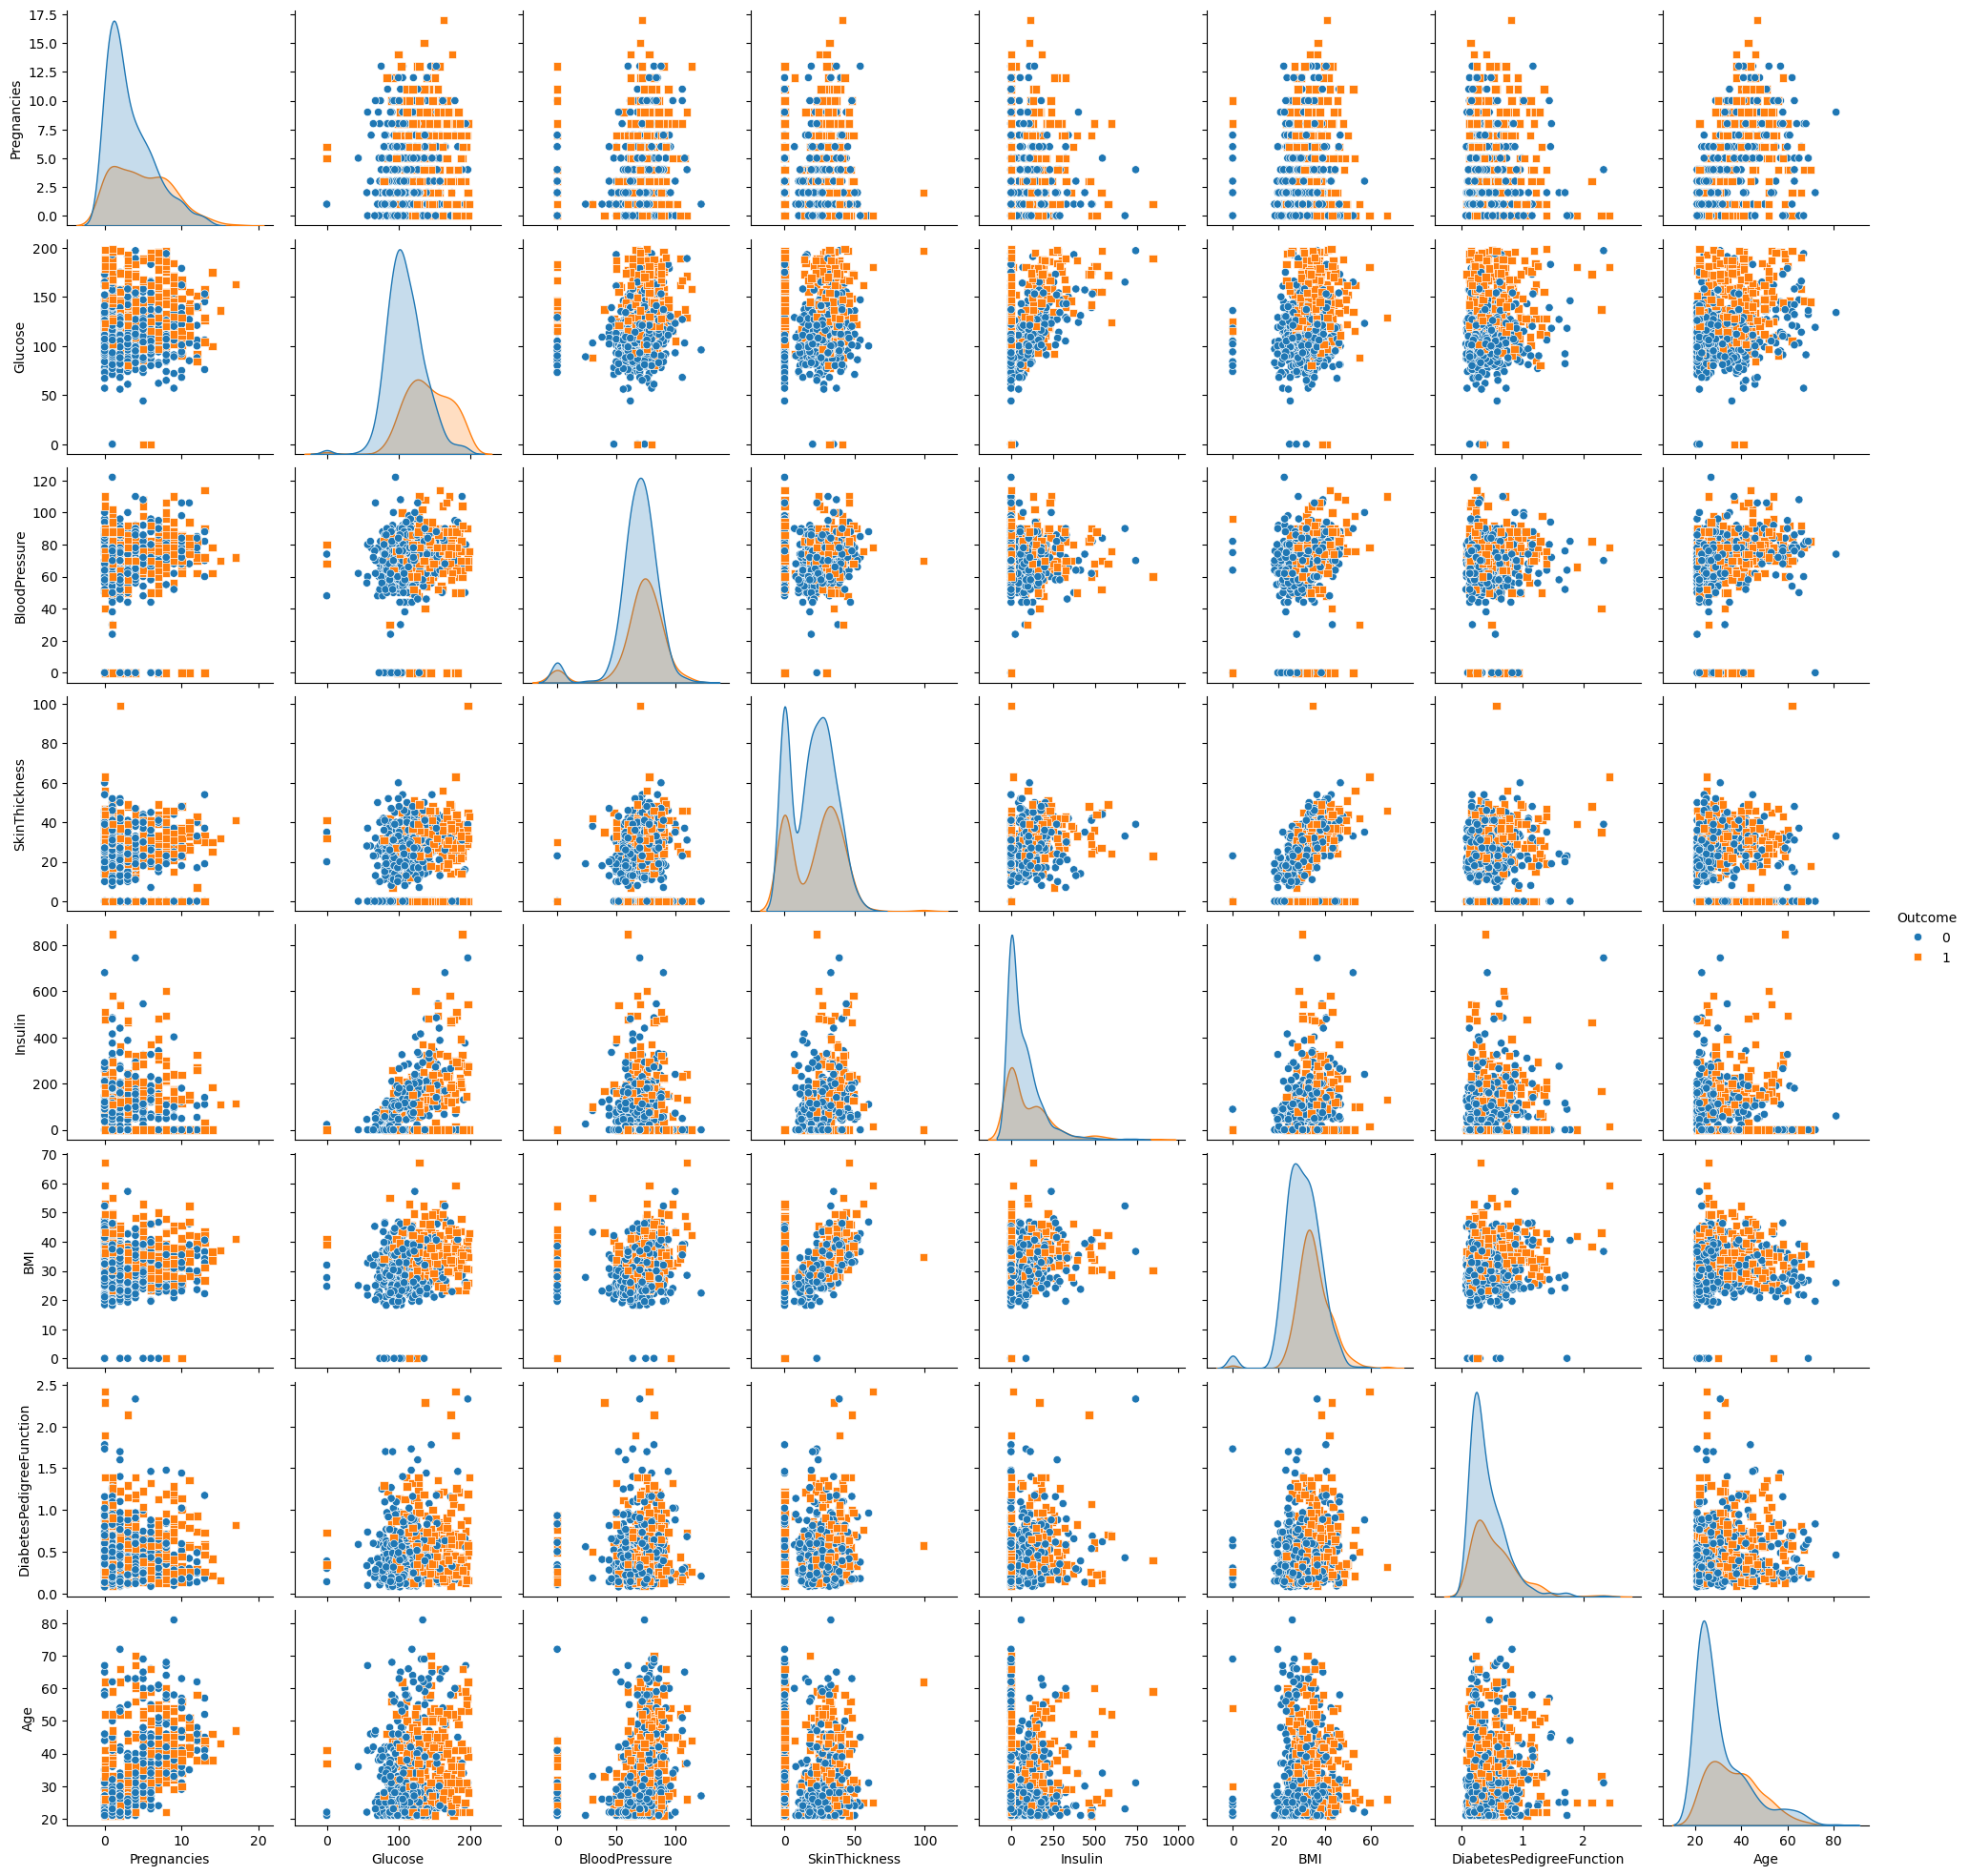

In [8]:
# pairplot for all features in the diabetes dataset with the hue based on 'Outcome'
sns.pairplot(diabetes_data, hue='Outcome', diag_kind='kde', markers=["o", "s"])
plt.show()
# most of the classes are skewed so we impute the data uing median

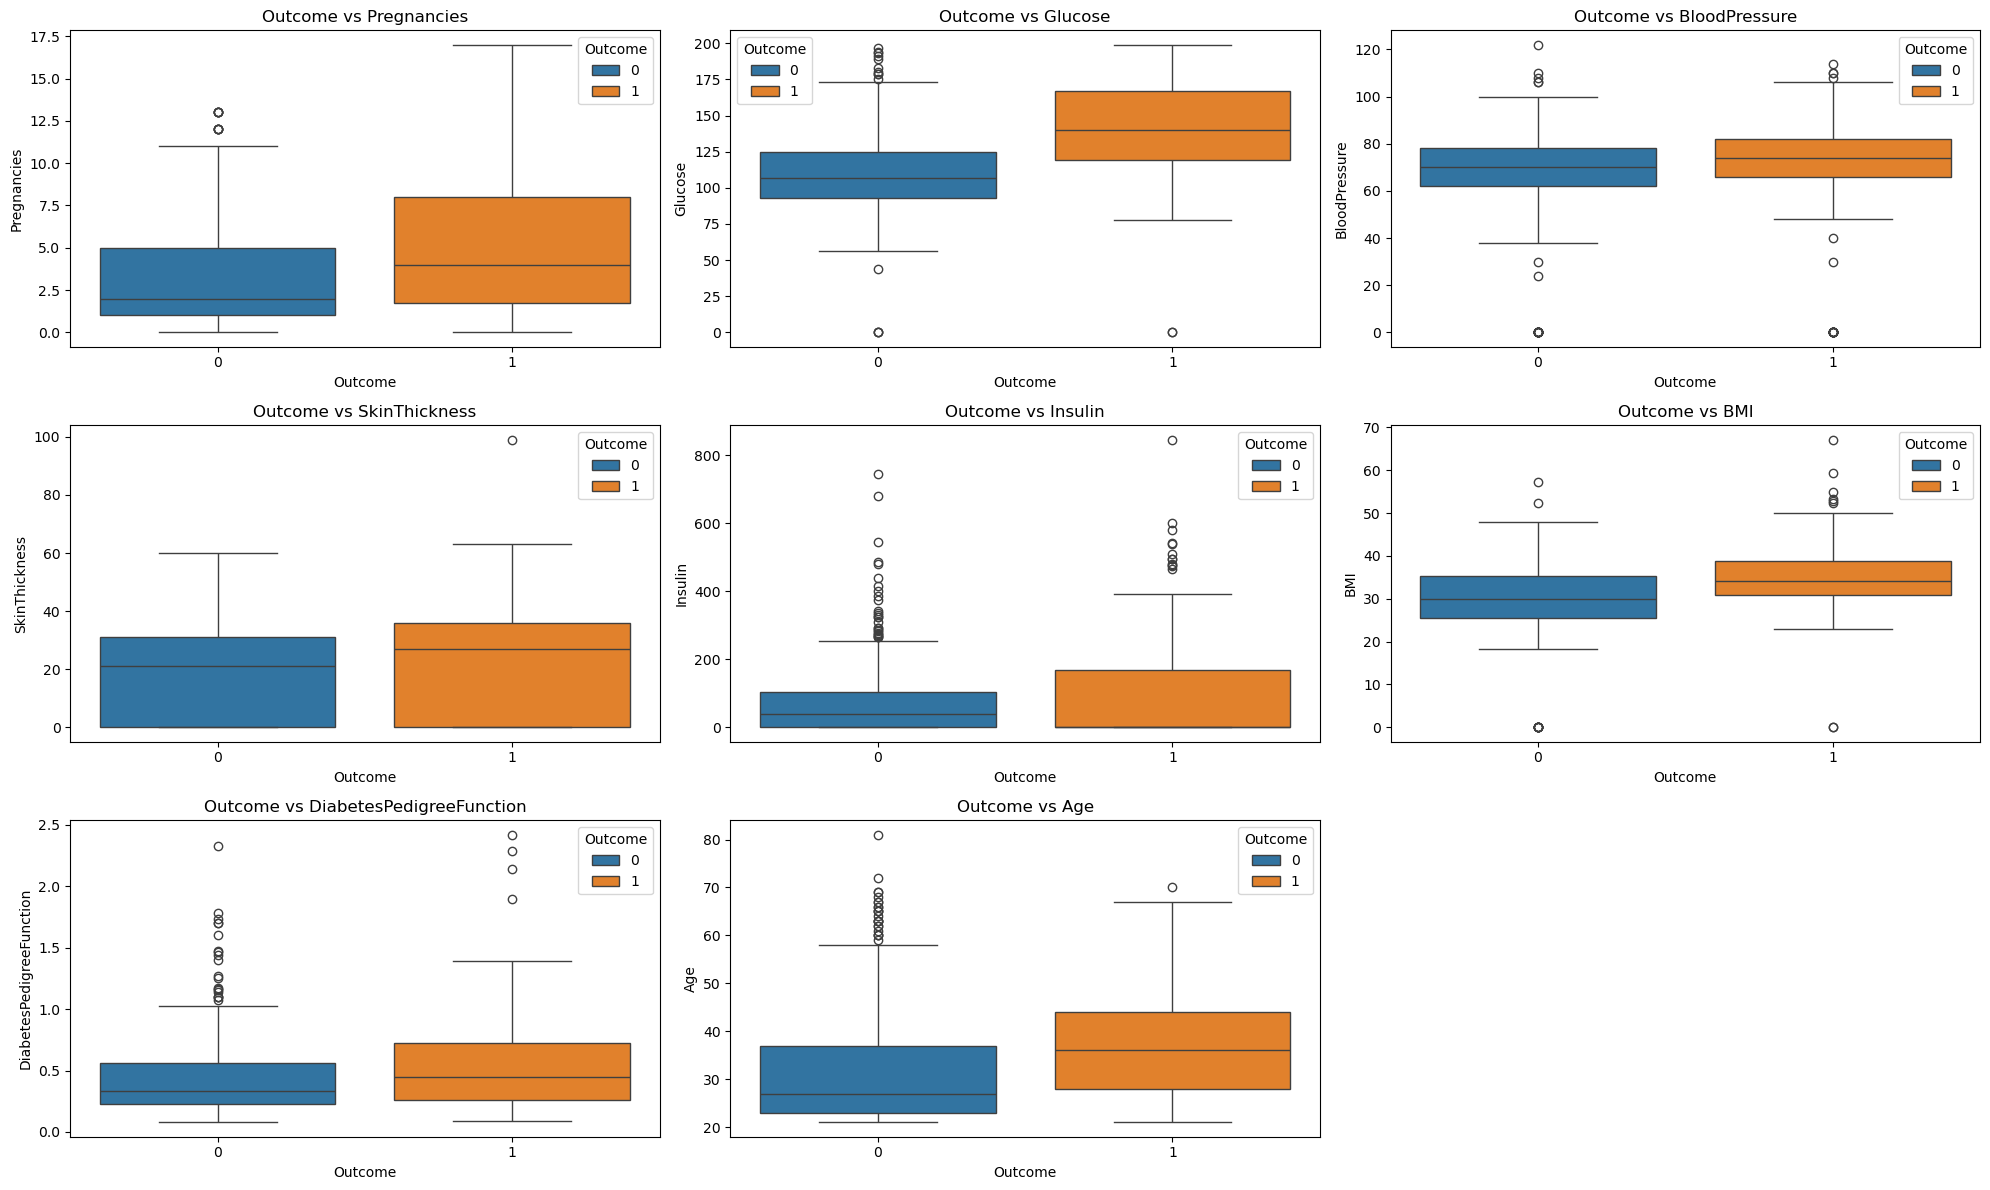

In [9]:
# List of features to plot
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
            'BMI', 'DiabetesPedigreeFunction', 'Age']

plt.figure(figsize=(20, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Outcome', y=feature, data=diabetes_data, hue='Outcome')
    plt.title(f'Outcome vs {feature}')

plt.tight_layout()
plt.show()

# features like 'Glucose','BloodPressure','SkinThickness','Insulin','BMI' have errornous data zero so we convert it tin NAN and impute using median
# since there are outlier even tough in acceptable range using Robust saclar which is insensitive to oulier is used.


In [10]:
diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN) 

In [11]:
diabetes_data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0      NaN  33.6   
1            1     85.0           66.0           29.0      NaN  26.6   
2            8    183.0           64.0            NaN      NaN  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# Data splitting and data pre-processing

In [3]:

# Split the dataset 
x = diabetes_data.iloc[:, :8]
y = diabetes_data["Outcome"]

# splitting data into train + validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, stratify=y, test_size=0.1, random_state=42)

# splitting train + validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.11, random_state=42)

# Print the shapes of the split data
print("Shape of training data:", x_train.shape)
print("Shape of validation data:", x_val.shape)
print("Shape of testing data:", x_test.shape)

# Convert data to numpy arrays 
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# preprocessing pipeline (imputation and scaling)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle NAN values by filling with median
    ('scaler', RobustScaler())  # Scale the data using RobustScaler
])

# Fitting the pipeline to the training data 
# transforming the training, validation, and testing data
x_train_preprocessed = pipeline.fit_transform(x_train)
x_val_preprocessed = pipeline.transform(x_val)
x_test_preprocessed = pipeline.transform(x_test)

# print label counts in the test dataset
unique, count = np.unique(y_test, return_counts=True)
print("Label counts in testing dataset:")
print(np.asarray((unique, count)).T)



Shape of training data: (614, 8)
Shape of validation data: (77, 8)
Shape of testing data: (77, 8)
Label counts in testing dataset:
[[ 0 50]
 [ 1 27]]


# BASELINE PERCEPTRON

In [60]:
# class weights for balancing the data
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                      classes=np.array([0, 1]), 
                                                      y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [91]:
# Setting seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Baseline mmodel of single-layer Perceptron using TensorFlow 
# The output layer has 2 units because we're using softmax for binary classification
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation='softmax', input_shape=(x_train_preprocessed.shape[1],))
])

# Compile the model with sparse categorical crossentropy
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Number of epochs
num_epochs = 100

# Train the model with validation data
history = model.fit(x_train_preprocessed, y_train, epochs=num_epochs, validation_data=(x_val_preprocessed, y_val), class_weight = class_weight_dict)

Epoch 1/100
20/20 [==============================] - 0s 6ms/step - loss: 3.7562 - accuracy: 0.4560 - val_loss: 3.4191 - val_accuracy: 0.4805
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 2.9683 - accuracy: 0.4544 - val_loss: 2.5366 - val_accuracy: 0.4675
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 2.1661 - accuracy: 0.4528 - val_loss: 1.7437 - val_accuracy: 0.4545
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 1.4751 - accuracy: 0.4772 - val_loss: 1.0576 - val_accuracy: 0.4805
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.9611 - accuracy: 0.5147 - val_loss: 0.6800 - val_accuracy: 0.6494
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7347 - accuracy: 0.5765 - val_loss: 0.6075 - val_accuracy: 0.6883
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.5977 - val_loss: 0.6041 - val_accuracy: 0.6883
Epoch 8/100
2

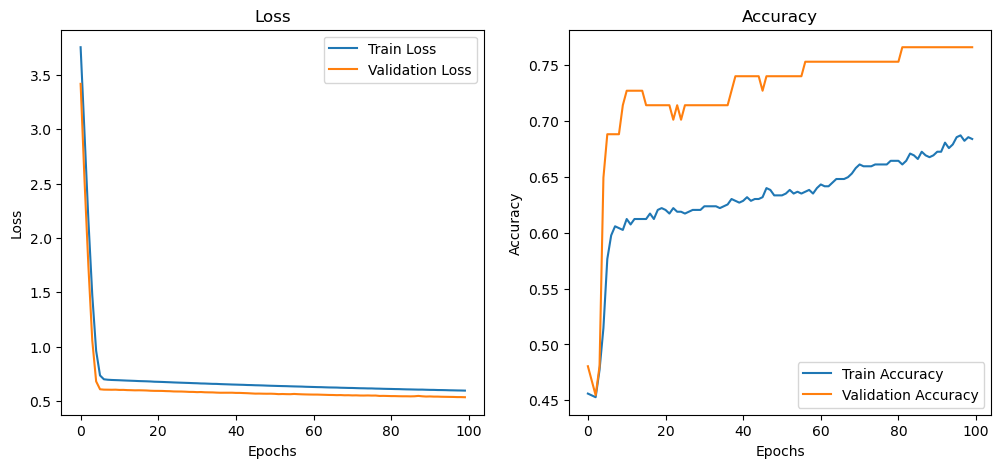

In [92]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# validation accuracy outperforms the training accuracy, which shows the model generalizes well on unseen data 
# but starts to overfit to the training data as evidenced by the divergence of training and validation accuracy.

# Both loss curves  remain quite close to each other, meaning the model minimized the prediction errors rapidly 
# and then stabilized-no significant overfitting.

In [93]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_preprocessed, y_test)
print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}')

#  classification report
y_pred = model.predict(x_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)  
print(classification_report(y_test, y_pred_classes))

3/3 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.6494
Test Loss: 0.6597 - Test Accuracy: 0.6494
3/3 [==============================] - 0s 555us/step
              precision    recall  f1-score   support

           0       0.79      0.62      0.70        50
           1       0.50      0.70      0.58        27

    accuracy                           0.65        77
   macro avg       0.65      0.66      0.64        77
weighted avg       0.69      0.65      0.66        77



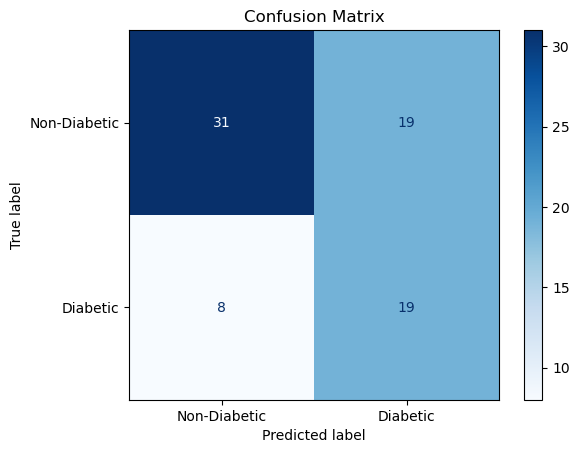

In [94]:
# Confusion Matrix
y_pred_classes = np.argmax(y_pred, axis=1)  
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# labels
labels = ['Non-Diabetic', 'Diabetic']

# confusion matrix with above specified labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

plt.title('Confusion Matrix')
plt.show()

# the model correctly predicts 31 non-diabetic and 19 diabetic instances. 
# However, there are 19 false positives (non-diabetic predicted as diabetic) and 8 false negatives (diabetic predicted as non-diabetic). 
# This indicates some misclassification with false positives, where the model predicts diabetes more frequently

# HYPERPARAMETER TUNING

In [37]:
# Hyperparameters 
learning_rates = [0.001, 0.01,0.1] # learning rates
optimizers = ['adam','sgd'] # optimiser
smoothing_values = [0.05, 0.1]  # Label smoothing
regularisation = [0.01, 0.001]  # L2 regularization

# Track the best model and hyperparameters
best_val_acc = 0.0
best_model = None
best_history = None
best_hyperparams = {}


Training with lr=0.001, optimizer=adam, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 2.8064 - accuracy: 0.4511 - val_loss: 2.7789 - val_accuracy: 0.4805 - 339ms/epoch - 17ms/step
Epoch 2/100
20/20 - 0s - loss: 2.7228 - accuracy: 0.4593 - val_loss: 2.6885 - val_accuracy: 0.4805 - 89ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 2.6385 - accuracy: 0.4577 - val_loss: 2.5961 - val_accuracy: 0.4935 - 111ms/epoch - 6ms/step
Epoch 4/100
20/20 - 0s - loss: 2.5537 - accuracy: 0.4625 - val_loss: 2.5080 - val_accuracy: 0.4935 - 94ms/epoch - 5ms/step
Epoch 5/100
20/20 - 0s - loss: 2.4715 - accuracy: 0.4658 - val_loss: 2.4174 - val_accuracy: 0.4935 - 72ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 2.3914 - accuracy: 0.4739 - val_loss: 2.3268 - val_accuracy: 0.5065 - 68ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 2.3077 - accuracy: 0.4756 - val_loss: 2.2395 - val_accuracy: 0.5065 - 63ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 2.2276 - accuracy: 0.4837 - 

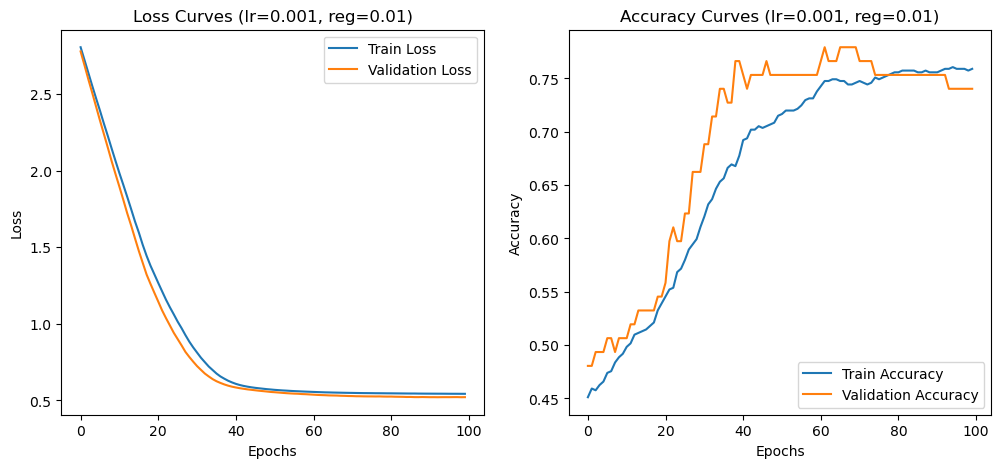


Training with lr=0.001, optimizer=adam, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 0.7007 - accuracy: 0.6694 - val_loss: 0.7753 - val_accuracy: 0.6494 - 313ms/epoch - 16ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6837 - accuracy: 0.6710 - val_loss: 0.7543 - val_accuracy: 0.6494 - 69ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6697 - accuracy: 0.6710 - val_loss: 0.7357 - val_accuracy: 0.6883 - 71ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6566 - accuracy: 0.6743 - val_loss: 0.7161 - val_accuracy: 0.6753 - 74ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6438 - accuracy: 0.6743 - val_loss: 0.6978 - val_accuracy: 0.6753 - 74ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6316 - accuracy: 0.6808 - val_loss: 0.6823 - val_accuracy: 0.6753 - 63ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6214 - accuracy: 0.6824 - val_loss: 0.6674 - val_accuracy: 0.6623 - 60ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.6117 - accuracy: 0.6873 - 

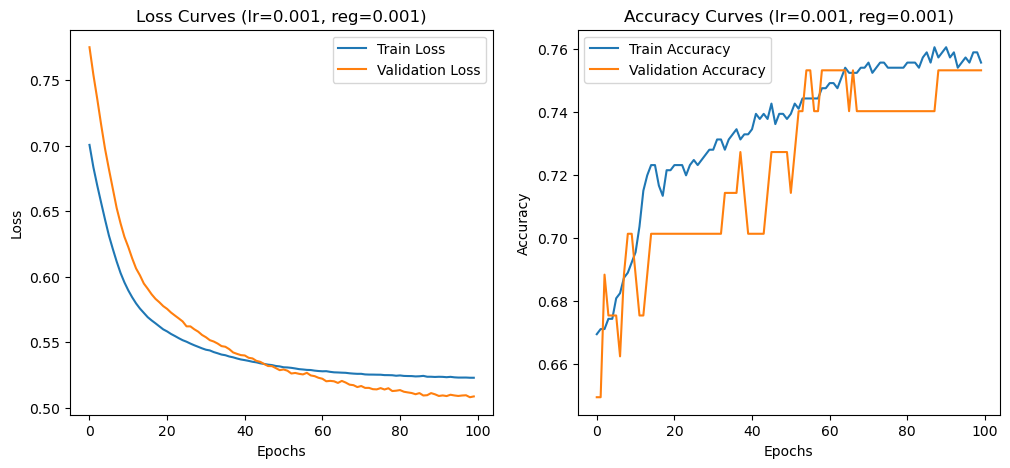


Training with lr=0.001, optimizer=adam, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 3.0656 - accuracy: 0.3534 - val_loss: 3.1409 - val_accuracy: 0.3636 - 349ms/epoch - 17ms/step
Epoch 2/100
20/20 - 0s - loss: 2.9703 - accuracy: 0.3550 - val_loss: 3.0377 - val_accuracy: 0.3636 - 101ms/epoch - 5ms/step
Epoch 3/100
20/20 - 0s - loss: 2.8747 - accuracy: 0.3664 - val_loss: 2.9331 - val_accuracy: 0.3766 - 101ms/epoch - 5ms/step
Epoch 4/100
20/20 - 0s - loss: 2.7789 - accuracy: 0.3697 - val_loss: 2.8336 - val_accuracy: 0.3766 - 71ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 2.6861 - accuracy: 0.3730 - val_loss: 2.7316 - val_accuracy: 0.3636 - 70ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 2.5951 - accuracy: 0.3746 - val_loss: 2.6297 - val_accuracy: 0.3896 - 69ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 2.5008 - accuracy: 0.3811 - val_loss: 2.5311 - val_accuracy: 0.3896 - 63ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 2.4100 - accuracy: 0.3893 - 

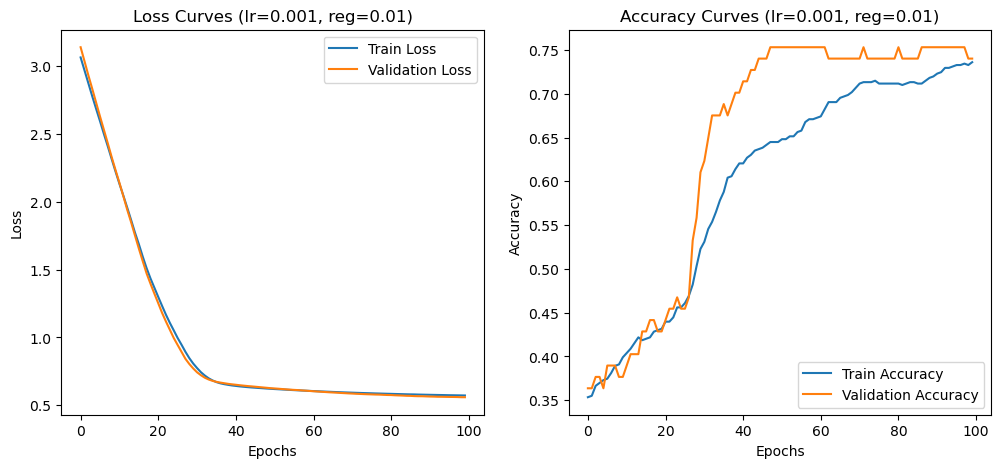


Training with lr=0.001, optimizer=adam, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 3.2213 - accuracy: 0.4381 - val_loss: 3.3821 - val_accuracy: 0.3636 - 355ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 3.1299 - accuracy: 0.4397 - val_loss: 3.2797 - val_accuracy: 0.3766 - 78ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 3.0377 - accuracy: 0.4479 - val_loss: 3.1760 - val_accuracy: 0.3766 - 95ms/epoch - 5ms/step
Epoch 4/100
20/20 - 0s - loss: 2.9457 - accuracy: 0.4511 - val_loss: 3.0772 - val_accuracy: 0.3766 - 79ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 2.8564 - accuracy: 0.4577 - val_loss: 2.9757 - val_accuracy: 0.3766 - 64ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 2.7690 - accuracy: 0.4609 - val_loss: 2.8744 - val_accuracy: 0.3766 - 61ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 2.6783 - accuracy: 0.4674 - val_loss: 2.7764 - val_accuracy: 0.3896 - 59ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 2.5911 - accuracy: 0.4707 - v

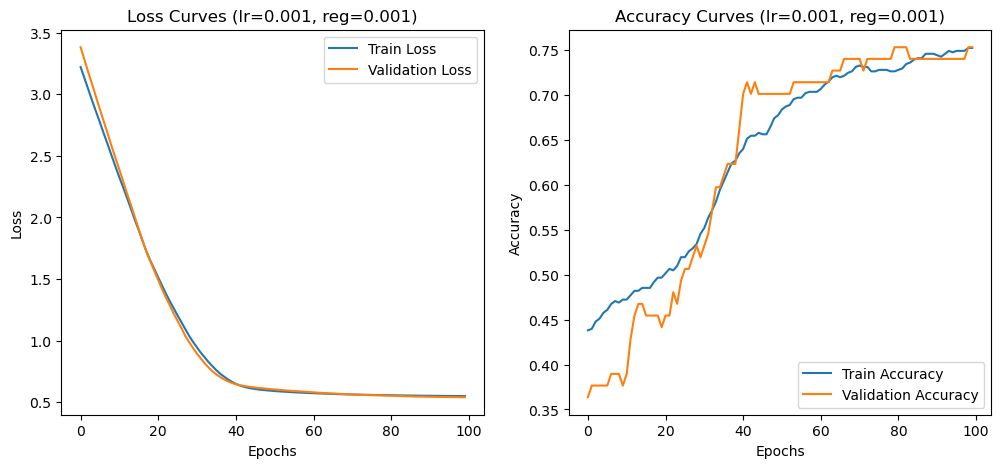


Training with lr=0.001, optimizer=sgd, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.4424 - accuracy: 0.6173 - val_loss: 1.6862 - val_accuracy: 0.7013 - 363ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 1.3972 - accuracy: 0.6173 - val_loss: 1.6303 - val_accuracy: 0.7013 - 89ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 1.3546 - accuracy: 0.6173 - val_loss: 1.5750 - val_accuracy: 0.7013 - 71ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 1.3131 - accuracy: 0.6173 - val_loss: 1.5176 - val_accuracy: 0.7013 - 72ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 1.2702 - accuracy: 0.6156 - val_loss: 1.4638 - val_accuracy: 0.7013 - 61ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 1.2302 - accuracy: 0.6124 - val_loss: 1.4104 - val_accuracy: 0.7013 - 70ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 1.1907 - accuracy: 0.6124 - val_loss: 1.3542 - val_accuracy: 0.7013 - 65ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 1.1492 - accuracy: 0.6107 - va

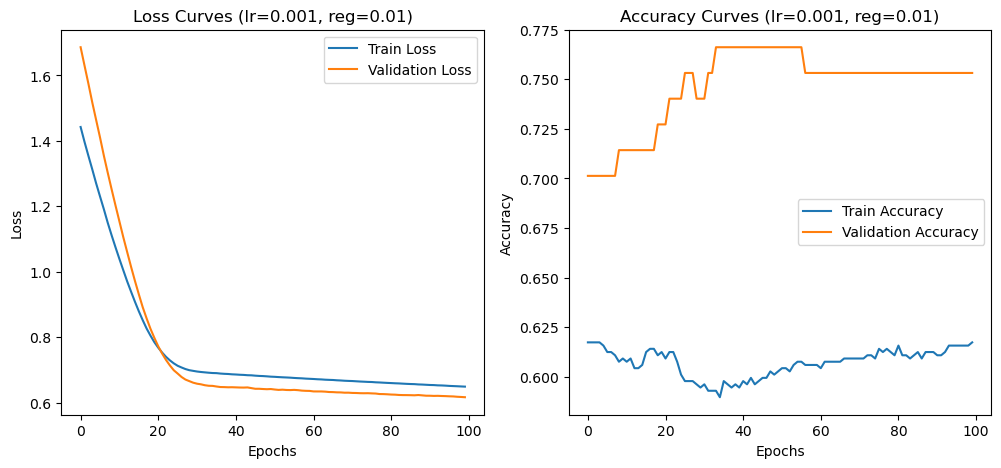


Training with lr=0.001, optimizer=sgd, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 3.6480 - accuracy: 0.3795 - val_loss: 3.6780 - val_accuracy: 0.3506 - 350ms/epoch - 17ms/step
Epoch 2/100
20/20 - 0s - loss: 3.2598 - accuracy: 0.3746 - val_loss: 3.2389 - val_accuracy: 0.3506 - 66ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 2.8542 - accuracy: 0.3730 - val_loss: 2.8273 - val_accuracy: 0.3506 - 67ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 2.4753 - accuracy: 0.3713 - val_loss: 2.4184 - val_accuracy: 0.3506 - 53ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 2.1041 - accuracy: 0.3779 - val_loss: 2.0315 - val_accuracy: 0.3506 - 56ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 1.7588 - accuracy: 0.3827 - val_loss: 1.6584 - val_accuracy: 0.3247 - 59ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 1.4340 - accuracy: 0.3941 - val_loss: 1.3326 - val_accuracy: 0.3247 - 61ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 1.1627 - accuracy: 0.3844 - v

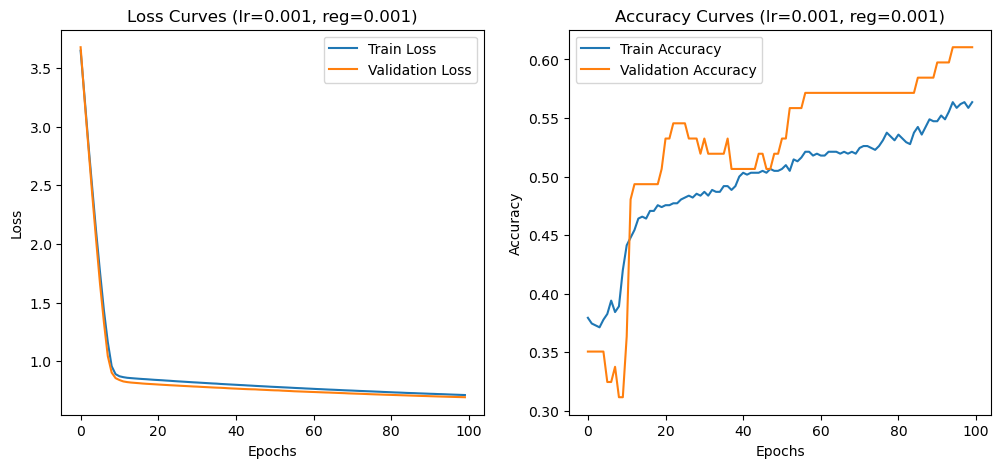


Training with lr=0.001, optimizer=sgd, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.6181 - accuracy: 0.5814 - val_loss: 1.8422 - val_accuracy: 0.5455 - 358ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 1.5673 - accuracy: 0.5814 - val_loss: 1.7811 - val_accuracy: 0.5455 - 72ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 1.5191 - accuracy: 0.5814 - val_loss: 1.7208 - val_accuracy: 0.5455 - 70ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 1.4721 - accuracy: 0.5814 - val_loss: 1.6583 - val_accuracy: 0.5455 - 81ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 1.4236 - accuracy: 0.5831 - val_loss: 1.5993 - val_accuracy: 0.5455 - 72ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 1.3779 - accuracy: 0.5847 - val_loss: 1.5409 - val_accuracy: 0.5455 - 60ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 1.3328 - accuracy: 0.5863 - val_loss: 1.4798 - val_accuracy: 0.5455 - 68ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 1.2856 - accuracy: 0.5863 - val

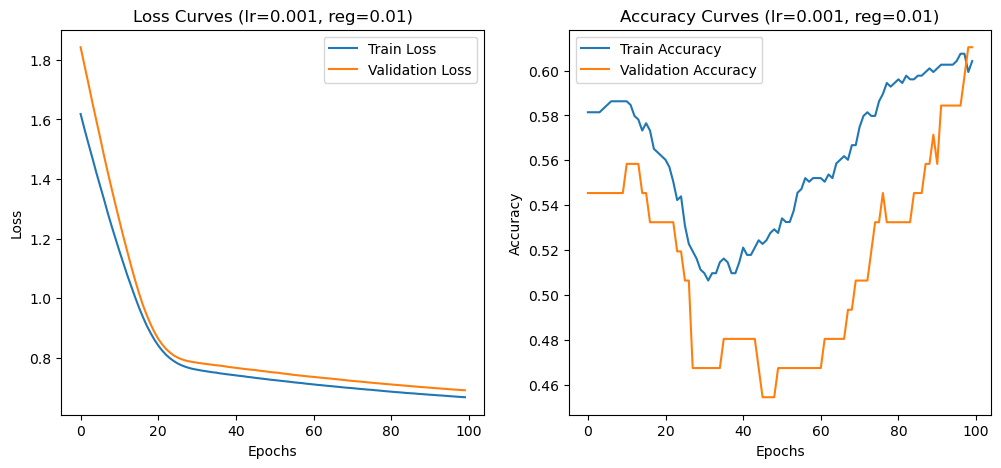


Training with lr=0.001, optimizer=sgd, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 1s - loss: 1.4193 - accuracy: 0.4153 - val_loss: 1.3026 - val_accuracy: 0.3636 - 553ms/epoch - 28ms/step
Epoch 2/100
20/20 - 0s - loss: 1.1500 - accuracy: 0.4235 - val_loss: 1.0296 - val_accuracy: 0.4026 - 66ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.9337 - accuracy: 0.4349 - val_loss: 0.8671 - val_accuracy: 0.4286 - 63ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.8293 - accuracy: 0.4642 - val_loss: 0.8101 - val_accuracy: 0.5065 - 68ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.8014 - accuracy: 0.4772 - val_loss: 0.7931 - val_accuracy: 0.5195 - 63ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.7921 - accuracy: 0.4837 - val_loss: 0.7852 - val_accuracy: 0.5325 - 60ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.7874 - accuracy: 0.4935 - val_loss: 0.7811 - val_accuracy: 0.5325 - 70ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7842 - accuracy: 0.5000 - va

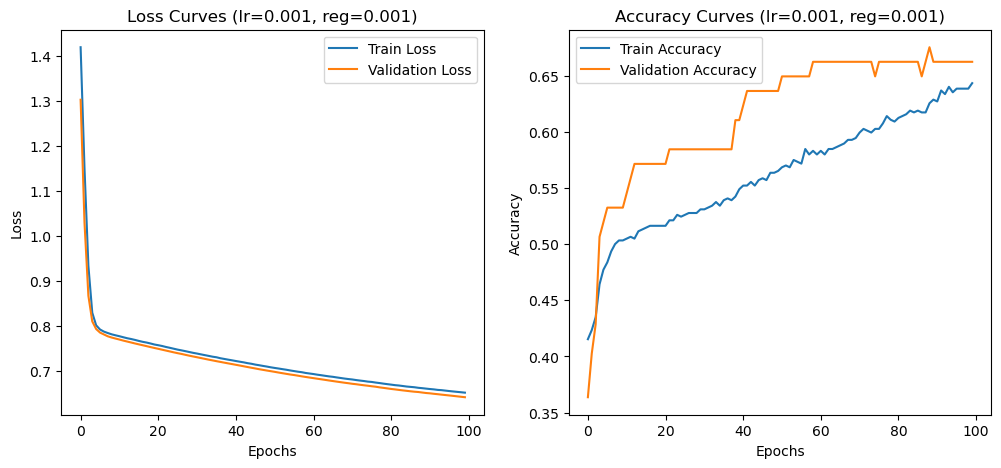


Training with lr=0.01, optimizer=adam, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 0.7523 - accuracy: 0.6775 - val_loss: 0.6724 - val_accuracy: 0.6753 - 333ms/epoch - 17ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6255 - accuracy: 0.6938 - val_loss: 0.5988 - val_accuracy: 0.7013 - 61ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.5881 - accuracy: 0.7117 - val_loss: 0.5764 - val_accuracy: 0.7143 - 71ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.5697 - accuracy: 0.7296 - val_loss: 0.5611 - val_accuracy: 0.7532 - 61ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5610 - accuracy: 0.7362 - val_loss: 0.5438 - val_accuracy: 0.7532 - 61ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.5517 - accuracy: 0.7394 - val_loss: 0.5394 - val_accuracy: 0.7532 - 71ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5481 - accuracy: 0.7476 - val_loss: 0.5270 - val_accuracy: 0.7662 - 125ms/epoch - 6ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5458 - accuracy: 0.7590 - v

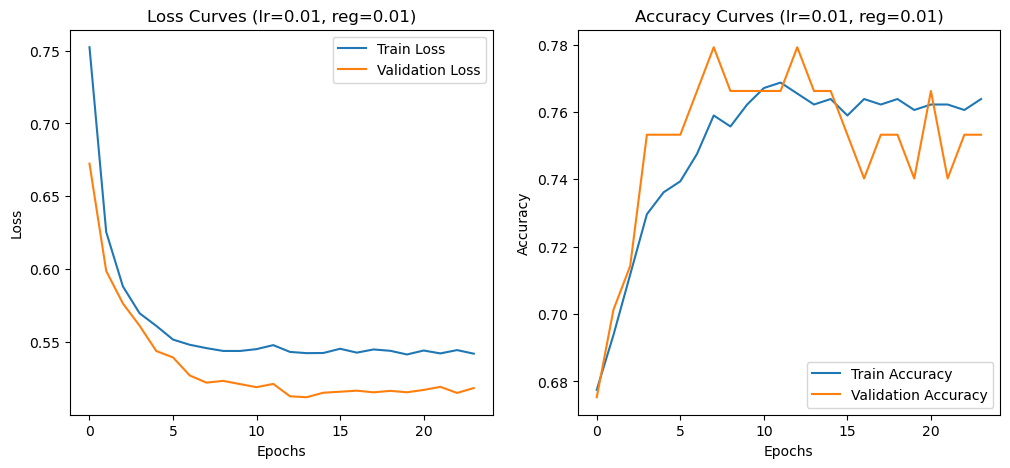


Training with lr=0.01, optimizer=adam, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 1.6842 - accuracy: 0.5309 - val_loss: 1.1261 - val_accuracy: 0.5455 - 393ms/epoch - 20ms/step
Epoch 2/100
20/20 - 0s - loss: 1.0104 - accuracy: 0.5831 - val_loss: 0.6264 - val_accuracy: 0.7013 - 64ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6476 - accuracy: 0.6645 - val_loss: 0.5587 - val_accuracy: 0.7403 - 61ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.5780 - accuracy: 0.7036 - val_loss: 0.5380 - val_accuracy: 0.7792 - 63ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5605 - accuracy: 0.7215 - val_loss: 0.5156 - val_accuracy: 0.7792 - 60ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.5466 - accuracy: 0.7410 - val_loss: 0.5052 - val_accuracy: 0.7792 - 60ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5388 - accuracy: 0.7524 - val_loss: 0.4976 - val_accuracy: 0.7922 - 101ms/epoch - 5ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5344 - accuracy: 0.7671 - 

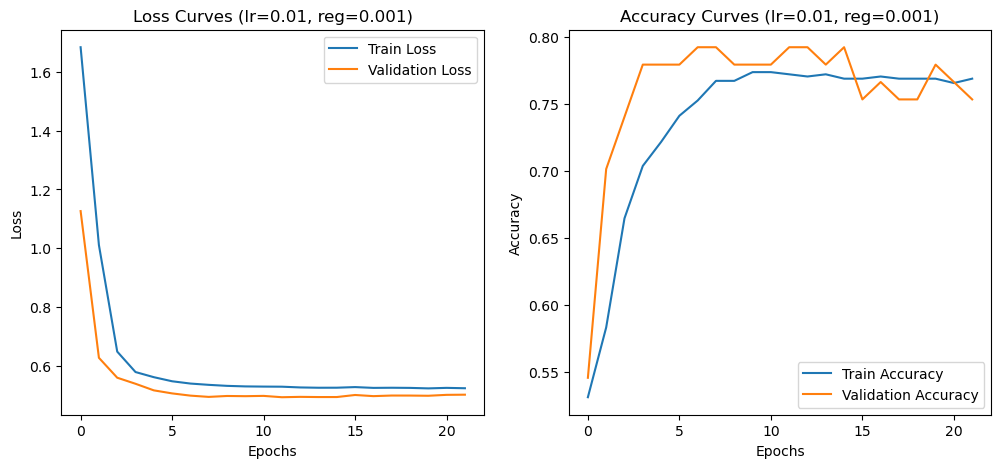


Training with lr=0.01, optimizer=adam, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.6010 - accuracy: 0.5423 - val_loss: 1.6166 - val_accuracy: 0.6234 - 364ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 1.3072 - accuracy: 0.5879 - val_loss: 1.2892 - val_accuracy: 0.6364 - 75ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 1.0514 - accuracy: 0.6140 - val_loss: 0.9966 - val_accuracy: 0.6753 - 61ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.8346 - accuracy: 0.6678 - val_loss: 0.7310 - val_accuracy: 0.7013 - 74ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6701 - accuracy: 0.7117 - val_loss: 0.5737 - val_accuracy: 0.7662 - 63ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6028 - accuracy: 0.7248 - val_loss: 0.5498 - val_accuracy: 0.7792 - 59ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5843 - accuracy: 0.7345 - val_loss: 0.5452 - val_accuracy: 0.8052 - 58ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5745 - accuracy: 0.7476 - val

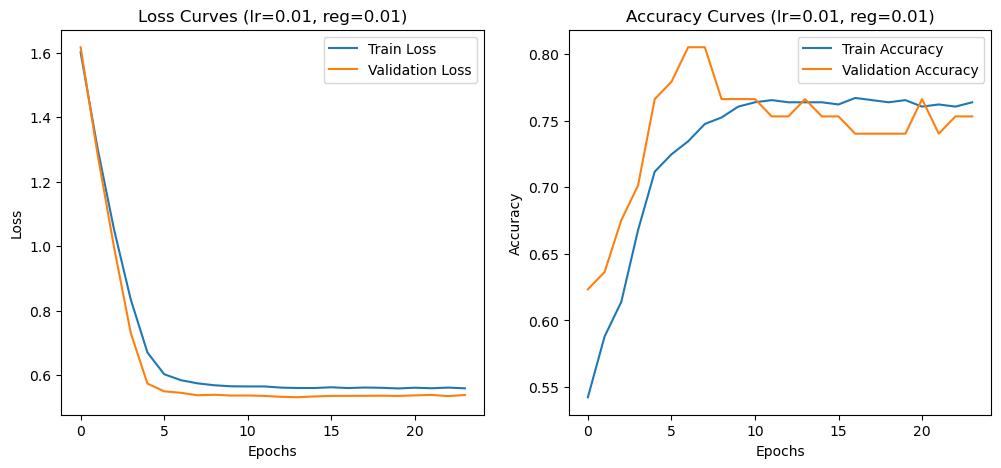


Training with lr=0.01, optimizer=adam, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 1.4744 - accuracy: 0.6010 - val_loss: 1.4825 - val_accuracy: 0.6364 - 360ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 1.1982 - accuracy: 0.6319 - val_loss: 1.1642 - val_accuracy: 0.6494 - 91ms/epoch - 5ms/step
Epoch 3/100
20/20 - 0s - loss: 0.9592 - accuracy: 0.6417 - val_loss: 0.8936 - val_accuracy: 0.6883 - 70ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.7694 - accuracy: 0.6596 - val_loss: 0.6693 - val_accuracy: 0.7013 - 78ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6424 - accuracy: 0.6743 - val_loss: 0.5720 - val_accuracy: 0.7403 - 71ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6001 - accuracy: 0.6873 - val_loss: 0.5610 - val_accuracy: 0.7532 - 56ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5807 - accuracy: 0.7182 - val_loss: 0.5490 - val_accuracy: 0.7792 - 63ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5687 - accuracy: 0.7313 - va

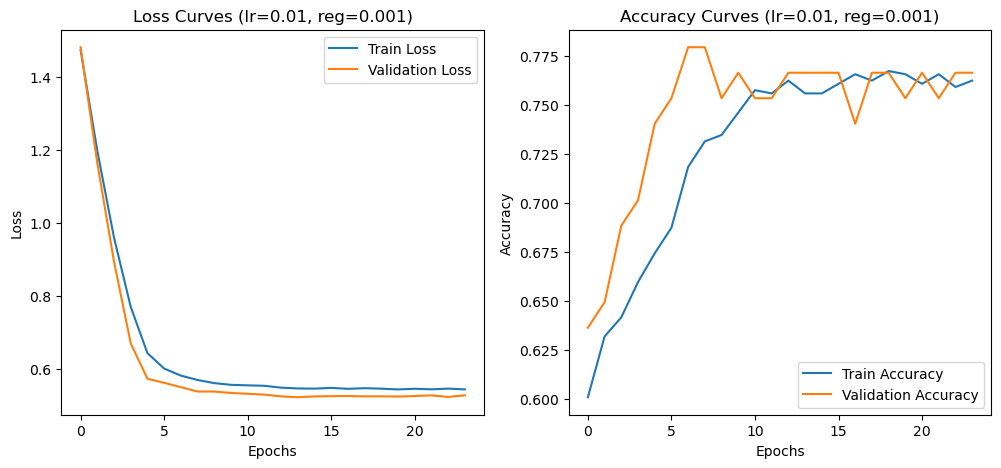


Training with lr=0.01, optimizer=sgd, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.1117 - accuracy: 0.5993 - val_loss: 0.9454 - val_accuracy: 0.6364 - 332ms/epoch - 17ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8395 - accuracy: 0.5684 - val_loss: 0.7568 - val_accuracy: 0.6623 - 121ms/epoch - 6ms/step
Epoch 3/100
20/20 - 0s - loss: 0.7582 - accuracy: 0.5717 - val_loss: 0.7008 - val_accuracy: 0.6234 - 92ms/epoch - 5ms/step
Epoch 4/100
20/20 - 0s - loss: 0.7422 - accuracy: 0.5586 - val_loss: 0.6909 - val_accuracy: 0.6234 - 76ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.7299 - accuracy: 0.5717 - val_loss: 0.6851 - val_accuracy: 0.6234 - 91ms/epoch - 5ms/step
Epoch 6/100
20/20 - 0s - loss: 0.7207 - accuracy: 0.5749 - val_loss: 0.6769 - val_accuracy: 0.6104 - 81ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.7117 - accuracy: 0.5831 - val_loss: 0.6649 - val_accuracy: 0.6234 - 71ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7020 - accuracy: 0.5798 - va

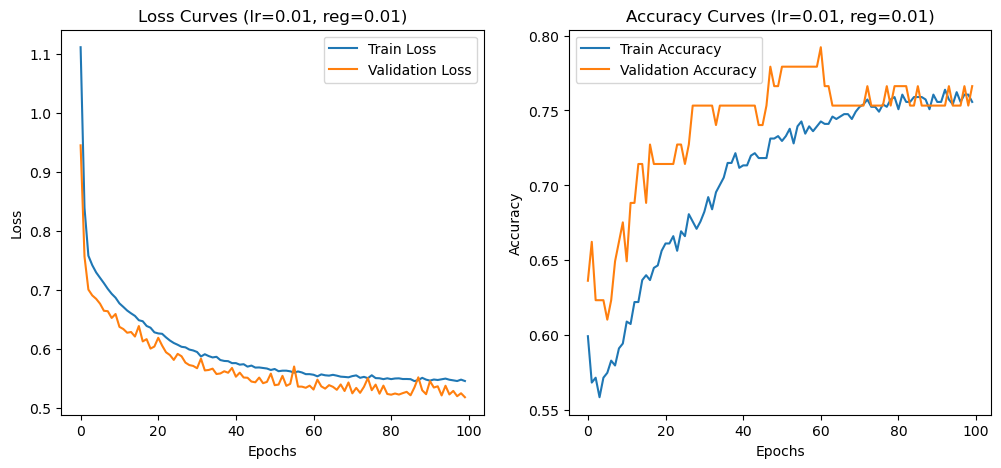


Training with lr=0.01, optimizer=sgd, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 0.6691 - accuracy: 0.6678 - val_loss: 0.5936 - val_accuracy: 0.7403 - 377ms/epoch - 19ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6238 - accuracy: 0.6661 - val_loss: 0.6046 - val_accuracy: 0.7273 - 71ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6151 - accuracy: 0.6678 - val_loss: 0.5837 - val_accuracy: 0.7403 - 60ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6112 - accuracy: 0.6694 - val_loss: 0.5810 - val_accuracy: 0.7403 - 61ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6104 - accuracy: 0.6710 - val_loss: 0.5849 - val_accuracy: 0.7403 - 70ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6058 - accuracy: 0.6743 - val_loss: 0.5734 - val_accuracy: 0.7403 - 60ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6036 - accuracy: 0.6726 - val_loss: 0.5653 - val_accuracy: 0.7403 - 70ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5988 - accuracy: 0.6808 - va

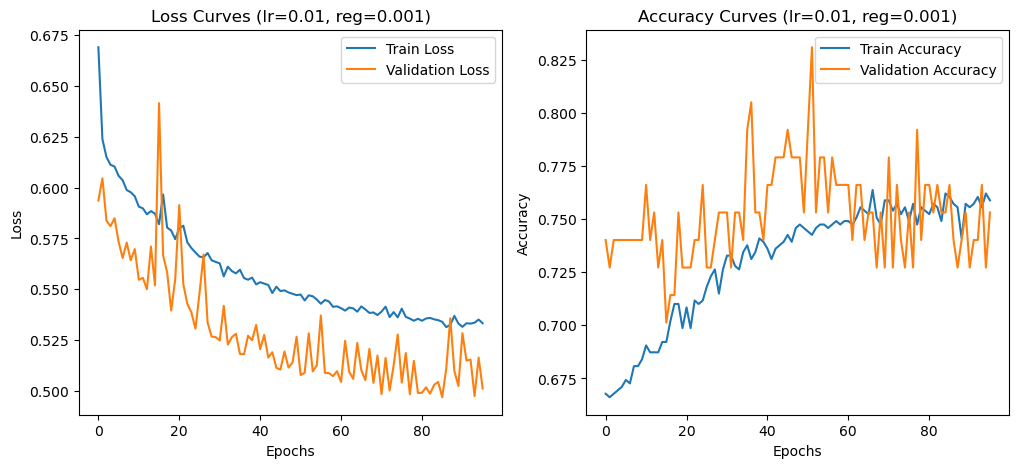


Training with lr=0.01, optimizer=sgd, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.3235 - accuracy: 0.5521 - val_loss: 1.1301 - val_accuracy: 0.5584 - 370ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 1.0709 - accuracy: 0.5000 - val_loss: 1.0001 - val_accuracy: 0.5325 - 70ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.9936 - accuracy: 0.4853 - val_loss: 0.9591 - val_accuracy: 0.4026 - 60ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.9582 - accuracy: 0.4739 - val_loss: 0.9321 - val_accuracy: 0.3766 - 59ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.9260 - accuracy: 0.4788 - val_loss: 0.9032 - val_accuracy: 0.4545 - 69ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.8968 - accuracy: 0.4870 - val_loss: 0.8801 - val_accuracy: 0.4286 - 62ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.8694 - accuracy: 0.4935 - val_loss: 0.8648 - val_accuracy: 0.3636 - 62ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.8435 - accuracy: 0.4967 - val_

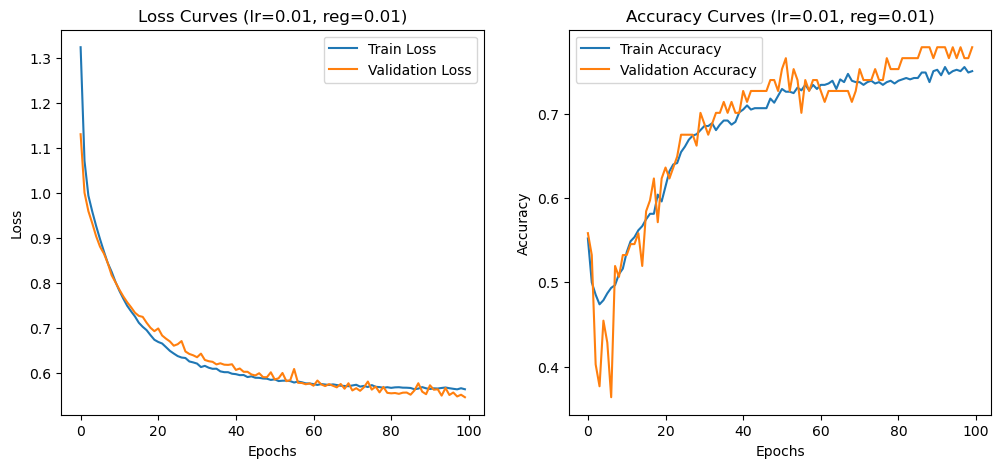


Training with lr=0.01, optimizer=sgd, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 2.1672 - accuracy: 0.4788 - val_loss: 0.7306 - val_accuracy: 0.5325 - 445ms/epoch - 22ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6777 - accuracy: 0.6059 - val_loss: 0.7058 - val_accuracy: 0.6104 - 100ms/epoch - 5ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6603 - accuracy: 0.6336 - val_loss: 0.6810 - val_accuracy: 0.5714 - 89ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6541 - accuracy: 0.6417 - val_loss: 0.6740 - val_accuracy: 0.5974 - 73ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6482 - accuracy: 0.6433 - val_loss: 0.6685 - val_accuracy: 0.6234 - 70ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6418 - accuracy: 0.6580 - val_loss: 0.6557 - val_accuracy: 0.6494 - 76ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6376 - accuracy: 0.6547 - val_loss: 0.6438 - val_accuracy: 0.6234 - 69ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.6310 - accuracy: 0.6596 - va

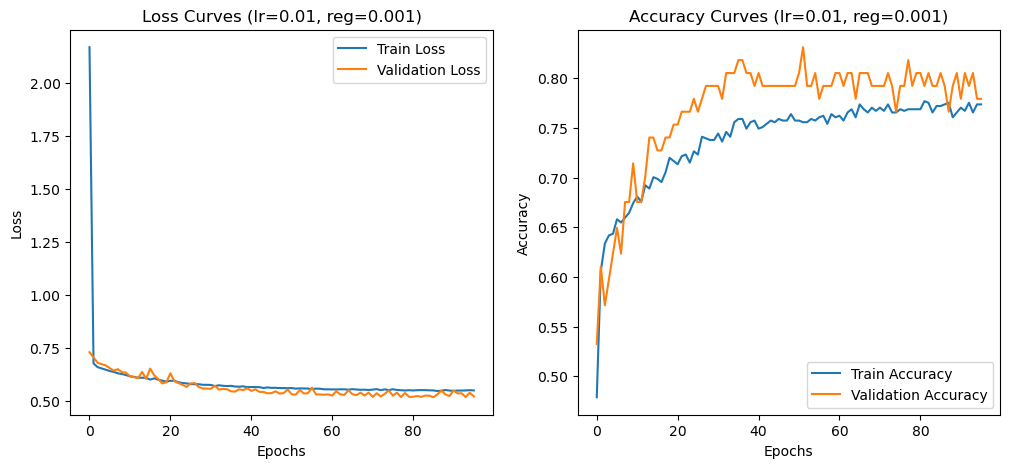


Training with lr=0.1, optimizer=adam, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 1.3320 - accuracy: 0.6156 - val_loss: 1.0250 - val_accuracy: 0.7143 - 424ms/epoch - 21ms/step
Epoch 2/100
20/20 - 0s - loss: 0.7603 - accuracy: 0.7410 - val_loss: 0.5100 - val_accuracy: 0.7662 - 74ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6027 - accuracy: 0.7248 - val_loss: 0.5395 - val_accuracy: 0.7273 - 84ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.5534 - accuracy: 0.7687 - val_loss: 0.5324 - val_accuracy: 0.7532 - 73ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5565 - accuracy: 0.7394 - val_loss: 0.5629 - val_accuracy: 0.7273 - 74ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.5837 - accuracy: 0.7443 - val_loss: 0.5709 - val_accuracy: 0.7143 - 68ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5628 - accuracy: 0.7606 - val_loss: 0.5069 - val_accuracy: 0.7792 - 80ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5528 - accuracy: 0.7573 - val

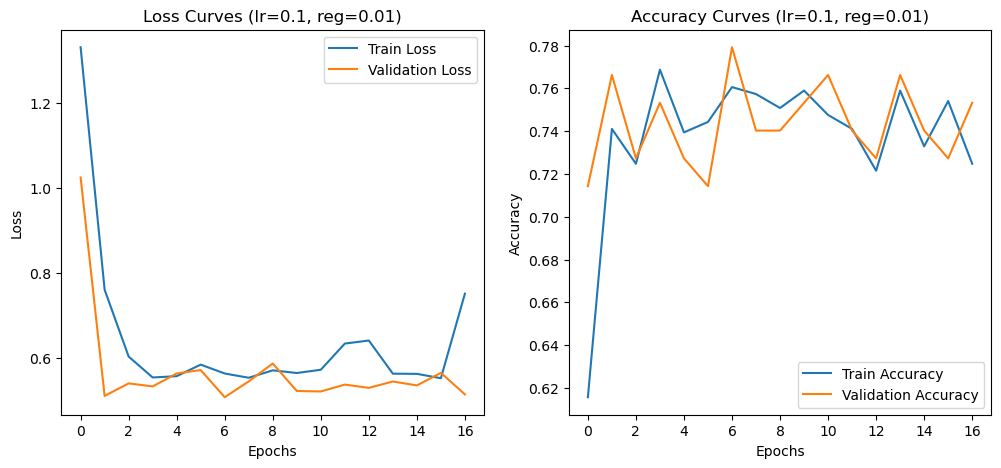


Training with lr=0.1, optimizer=adam, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 0.6525 - accuracy: 0.6694 - val_loss: 0.6924 - val_accuracy: 0.7273 - 376ms/epoch - 19ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6193 - accuracy: 0.7476 - val_loss: 0.7172 - val_accuracy: 0.7403 - 72ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.5818 - accuracy: 0.7345 - val_loss: 0.5783 - val_accuracy: 0.7273 - 60ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.5649 - accuracy: 0.7557 - val_loss: 0.5975 - val_accuracy: 0.7403 - 71ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5501 - accuracy: 0.7264 - val_loss: 0.6380 - val_accuracy: 0.7532 - 61ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.5855 - accuracy: 0.7476 - val_loss: 0.5117 - val_accuracy: 0.7403 - 61ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5392 - accuracy: 0.7590 - val_loss: 0.4916 - val_accuracy: 0.7792 - 60ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5339 - accuracy: 0.7590 - va

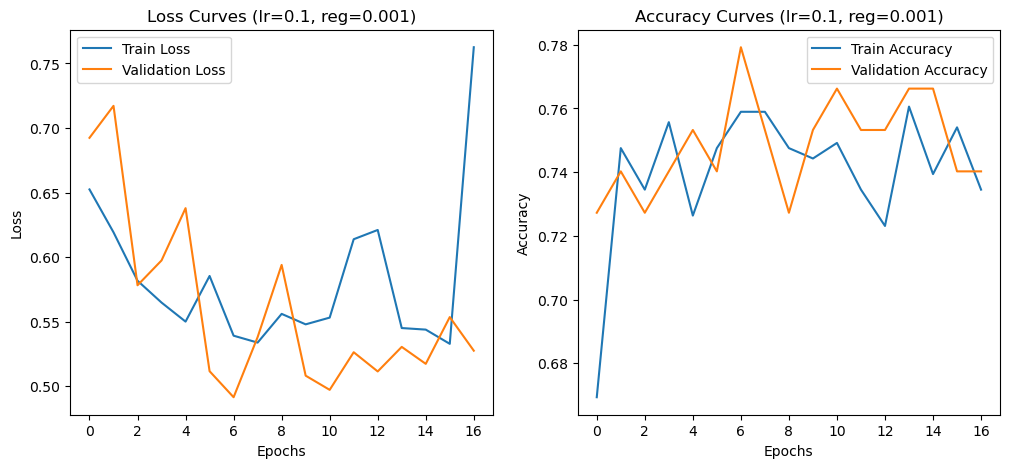


Training with lr=0.1, optimizer=adam, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 0.6986 - accuracy: 0.6042 - val_loss: 0.5123 - val_accuracy: 0.8052 - 376ms/epoch - 19ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6152 - accuracy: 0.7557 - val_loss: 0.6540 - val_accuracy: 0.7403 - 82ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.5910 - accuracy: 0.7362 - val_loss: 0.5251 - val_accuracy: 0.7662 - 73ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.5712 - accuracy: 0.7590 - val_loss: 0.5416 - val_accuracy: 0.7403 - 71ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5854 - accuracy: 0.7296 - val_loss: 0.5903 - val_accuracy: 0.7273 - 82ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6278 - accuracy: 0.7427 - val_loss: 0.6456 - val_accuracy: 0.7143 - 70ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6138 - accuracy: 0.7443 - val_loss: 0.5284 - val_accuracy: 0.7922 - 60ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5935 - accuracy: 0.7443 - val_

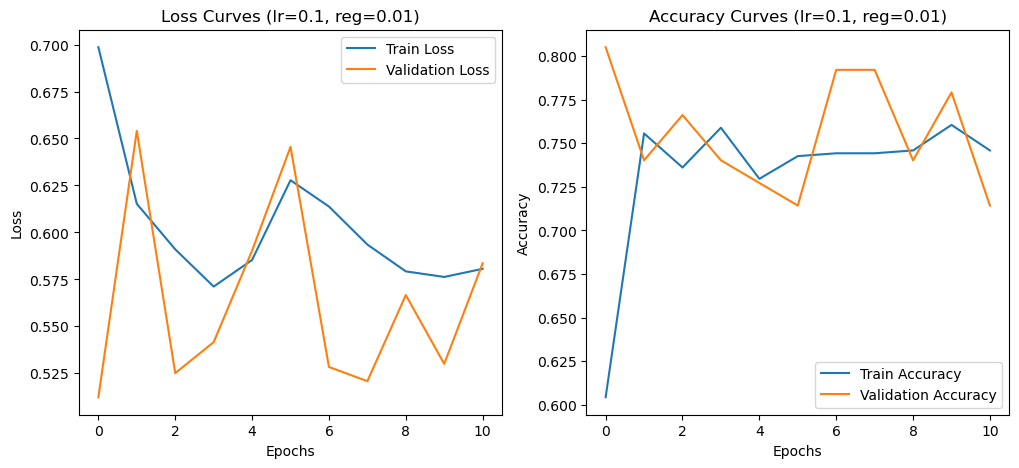


Training with lr=0.1, optimizer=adam, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 0.7139 - accuracy: 0.6840 - val_loss: 0.8366 - val_accuracy: 0.7273 - 392ms/epoch - 20ms/step
Epoch 2/100
20/20 - 0s - loss: 0.6464 - accuracy: 0.7459 - val_loss: 0.6513 - val_accuracy: 0.7403 - 91ms/epoch - 5ms/step
Epoch 3/100
20/20 - 0s - loss: 0.5785 - accuracy: 0.7508 - val_loss: 0.6520 - val_accuracy: 0.7143 - 72ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6024 - accuracy: 0.7508 - val_loss: 0.6495 - val_accuracy: 0.7273 - 80ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.5730 - accuracy: 0.7296 - val_loss: 0.6729 - val_accuracy: 0.7532 - 62ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6167 - accuracy: 0.7459 - val_loss: 0.5566 - val_accuracy: 0.7403 - 61ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5634 - accuracy: 0.7524 - val_loss: 0.5128 - val_accuracy: 0.7662 - 60ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.5535 - accuracy: 0.7541 - val

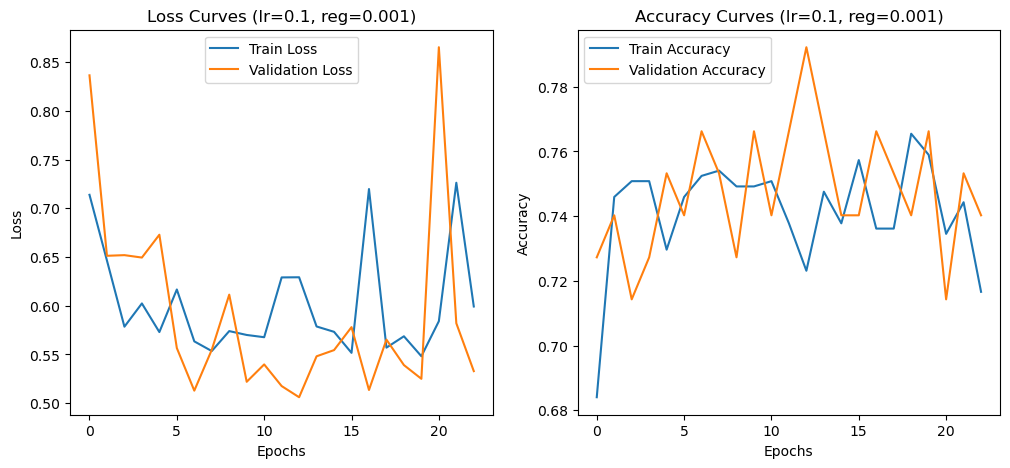


Training with lr=0.1, optimizer=sgd, smoothing=0.05, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 0.7903 - accuracy: 0.6466 - val_loss: 0.8782 - val_accuracy: 0.4805 - 381ms/epoch - 19ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8030 - accuracy: 0.6694 - val_loss: 0.8391 - val_accuracy: 0.7403 - 98ms/epoch - 5ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6595 - accuracy: 0.7248 - val_loss: 0.6195 - val_accuracy: 0.7532 - 81ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6599 - accuracy: 0.7476 - val_loss: 0.5602 - val_accuracy: 0.7792 - 71ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6665 - accuracy: 0.7215 - val_loss: 0.5876 - val_accuracy: 0.7662 - 90ms/epoch - 5ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6665 - accuracy: 0.7508 - val_loss: 0.6295 - val_accuracy: 0.7273 - 71ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5943 - accuracy: 0.7410 - val_loss: 0.5214 - val_accuracy: 0.8052 - 71ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7181 - accuracy: 0.7329 - val_

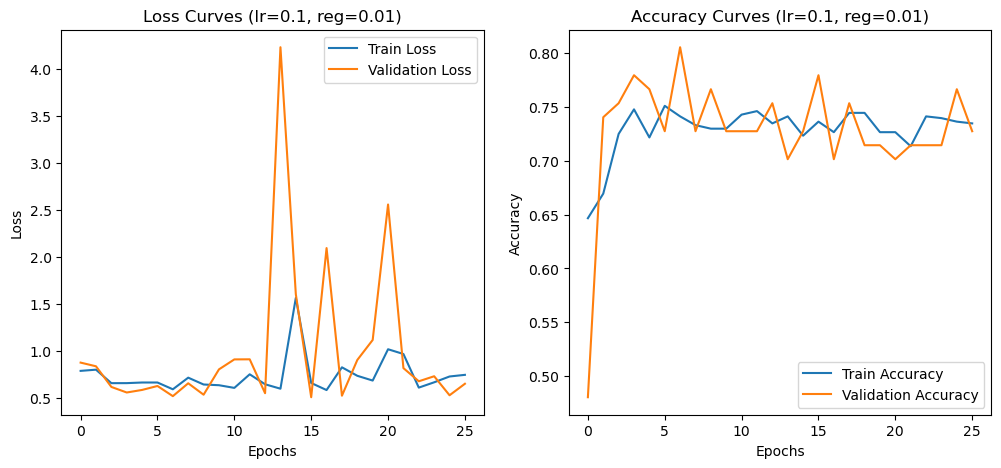


Training with lr=0.1, optimizer=sgd, smoothing=0.05, regularisation=0.001
Epoch 1/100
20/20 - 1s - loss: 0.7504 - accuracy: 0.6792 - val_loss: 0.9142 - val_accuracy: 0.5584 - 505ms/epoch - 25ms/step
Epoch 2/100
20/20 - 0s - loss: 0.7657 - accuracy: 0.6873 - val_loss: 0.8130 - val_accuracy: 0.7143 - 76ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6402 - accuracy: 0.7166 - val_loss: 0.6205 - val_accuracy: 0.7532 - 70ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6301 - accuracy: 0.7182 - val_loss: 0.5567 - val_accuracy: 0.7662 - 72ms/epoch - 4ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6442 - accuracy: 0.7003 - val_loss: 0.5753 - val_accuracy: 0.7662 - 70ms/epoch - 4ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6662 - accuracy: 0.7345 - val_loss: 0.6082 - val_accuracy: 0.7403 - 69ms/epoch - 3ms/step
Epoch 7/100
20/20 - 0s - loss: 0.5771 - accuracy: 0.7362 - val_loss: 0.5003 - val_accuracy: 0.8052 - 74ms/epoch - 4ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7113 - accuracy: 0.7362 - val

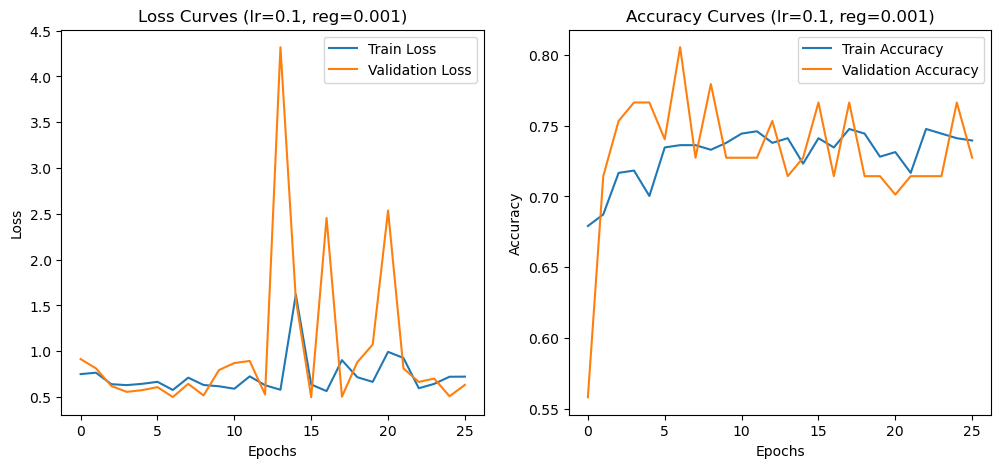


Training with lr=0.1, optimizer=sgd, smoothing=0.1, regularisation=0.01
Epoch 1/100
20/20 - 0s - loss: 0.8438 - accuracy: 0.5651 - val_loss: 1.0146 - val_accuracy: 0.4675 - 363ms/epoch - 18ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8476 - accuracy: 0.6303 - val_loss: 0.8880 - val_accuracy: 0.7013 - 70ms/epoch - 4ms/step
Epoch 3/100
20/20 - 0s - loss: 0.6973 - accuracy: 0.6889 - val_loss: 0.6567 - val_accuracy: 0.7403 - 70ms/epoch - 4ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6903 - accuracy: 0.7036 - val_loss: 0.6062 - val_accuracy: 0.7273 - 61ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6973 - accuracy: 0.6922 - val_loss: 0.5913 - val_accuracy: 0.7662 - 61ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.6849 - accuracy: 0.7280 - val_loss: 0.6738 - val_accuracy: 0.7143 - 71ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6110 - accuracy: 0.7410 - val_loss: 0.5899 - val_accuracy: 0.7403 - 91ms/epoch - 5ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7202 - accuracy: 0.7231 - val_l

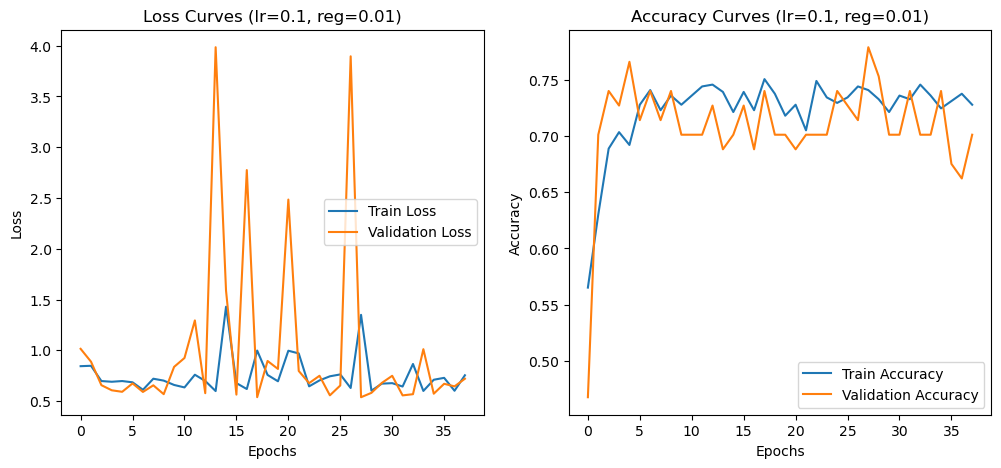


Training with lr=0.1, optimizer=sgd, smoothing=0.1, regularisation=0.001
Epoch 1/100
20/20 - 0s - loss: 0.9437 - accuracy: 0.5163 - val_loss: 1.0485 - val_accuracy: 0.3766 - 377ms/epoch - 19ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8778 - accuracy: 0.5993 - val_loss: 0.8974 - val_accuracy: 0.6753 - 68ms/epoch - 3ms/step
Epoch 3/100
20/20 - 0s - loss: 0.7456 - accuracy: 0.6547 - val_loss: 0.6832 - val_accuracy: 0.7013 - 60ms/epoch - 3ms/step
Epoch 4/100
20/20 - 0s - loss: 0.6891 - accuracy: 0.6808 - val_loss: 0.5863 - val_accuracy: 0.7143 - 61ms/epoch - 3ms/step
Epoch 5/100
20/20 - 0s - loss: 0.6968 - accuracy: 0.6759 - val_loss: 0.6130 - val_accuracy: 0.7143 - 60ms/epoch - 3ms/step
Epoch 6/100
20/20 - 0s - loss: 0.7139 - accuracy: 0.7150 - val_loss: 0.6327 - val_accuracy: 0.7013 - 71ms/epoch - 4ms/step
Epoch 7/100
20/20 - 0s - loss: 0.6269 - accuracy: 0.6873 - val_loss: 0.6041 - val_accuracy: 0.7143 - 50ms/epoch - 3ms/step
Epoch 8/100
20/20 - 0s - loss: 0.7595 - accuracy: 0.7101 - val_

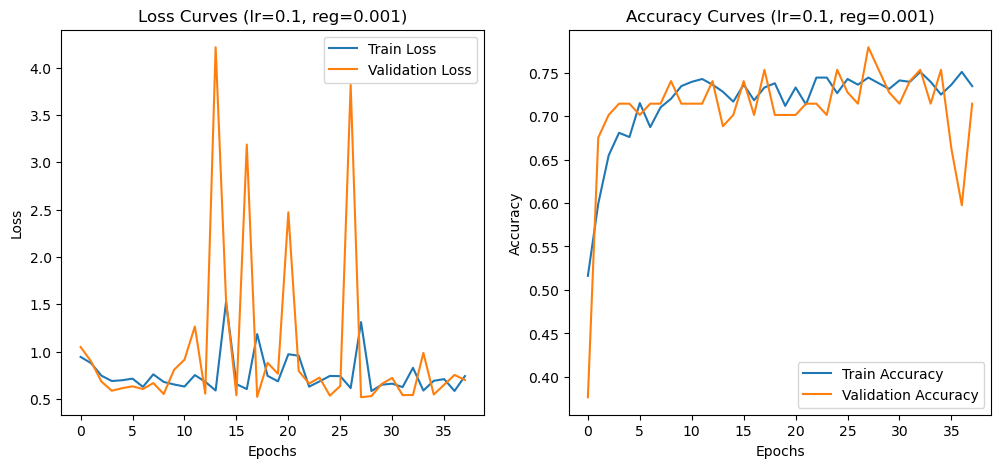

The best validation accuracy: 0.8051947951316833
Best Hyperparameters: {'learning_rate': 0.01, 'optimizer': 'sgd', 'smoothing': 0.1, 'regularisation': 0.001}


In [38]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Iterate over hyperparameters
for lr in learning_rates:
    for optimizer_name in optimizers:
        for smoothing in smoothing_values:
            for reg in regularisation:
                print(f"\nTraining with lr={lr}, optimizer={optimizer_name}, smoothing={smoothing}, regularisation={reg}")

                # Modelling single-layer Perceptron model with dropout, regularization (no hidden layers)
                model = tf.keras.Sequential([
                    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_train_preprocessed.shape[1],),
                                          kernel_regularizer=tf.keras.regularizers.l2(reg))
                ])

                # Choose optimizer
                if optimizer_name == 'adam':
                    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                else:
                    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

                # Compile the model with label smoothing applied to binary crossentropy
                loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=smoothing)
                model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                # EarlyStopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

                # Train the model with validation data and early stopping
                history = model.fit(
                    x_train_preprocessed, y_train,
                    epochs=100,
                    validation_data=(x_val_preprocessed, y_val),
                    callbacks=[early_stopping], 
                    verbose=2,
                    class_weight=class_weight_dict
                )

                # Evaluating the model on the validation set
                val_loss, val_acc = model.evaluate(x_val_preprocessed, y_val, verbose=0)
                print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

                # Plot the training and validation loss and accuracy 
                plt.figure(figsize=(12, 5))

                # training and validation loss
                plt.subplot(1, 2, 1)
                plt.plot(history.history['loss'], label='Train Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f"Loss Curves (lr={lr}, reg={reg})")
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()

                #  training and validation accuracy
                plt.subplot(1, 2, 2)
                plt.plot(history.history['accuracy'], label='Train Accuracy')
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
                plt.title(f"Accuracy Curves (lr={lr}, reg={reg})")
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.show()

                # Track the best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model
                    best_history = history
                    best_hyperparams = {
                        'learning_rate': lr,
                        'optimizer': optimizer_name,
                        'smoothing': smoothing,
                        'regularisation': reg
                    }

# Print the best hyperparameters
print("The best validation accuracy:", best_val_acc)
print("Best Hyperparameters:", best_hyperparams)


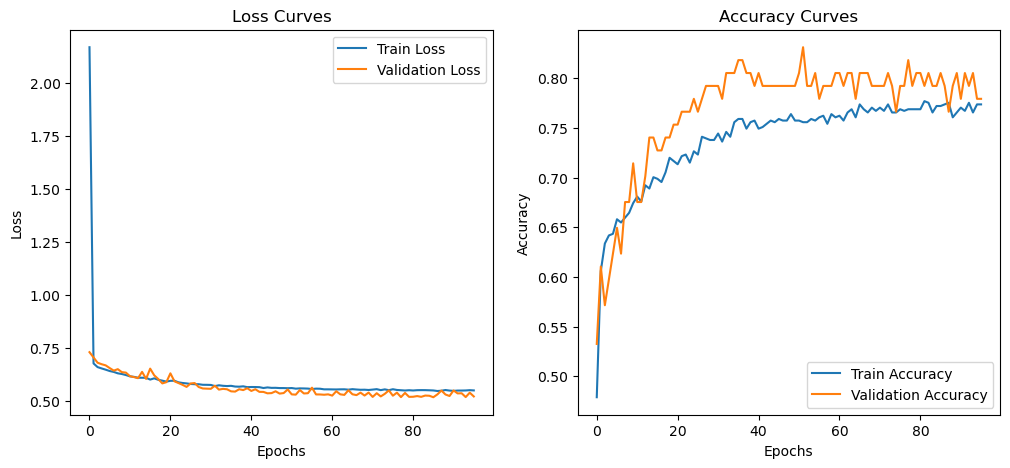

In [39]:
# Plot the training and validation loss and accuracy for the best model
plt.figure(figsize=(12, 5))

#training and validation loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# the losses in training and validation decrease and stabilize close to each other; 
# hence, the model doesn't exhibit any overfitting and reflects good generalization on unseen data in the validation set.

# the training and validation accuracy curves are converging; 
# the validation accuracy is very close to that of training accuracy meaning the model 
# when hyperparameters are tuned-generalizes well with no significant variance between training and validation.


In [40]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")


Best Hyperparameters:
learning_rate: 0.01
optimizer: sgd
smoothing: 0.1
regularisation: 0.001


3/3 [==============================] - 0s 0s/step


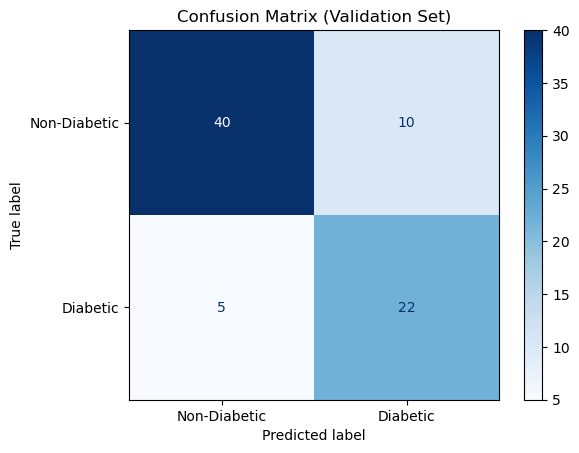

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [41]:
# Predict on the validation set and compute confusion matrix
y_val_pred = best_model.predict(x_val_preprocessed)
y_val_pred_classes = np.round(y_val_pred).astype(int)  # Binary classification with sigmoid output

conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Define the labels
labels = ['Non-Diabetic', 'Diabetic']

# Display the confusion matrix with above specified labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()
plt.figure(figsize=(12, 5))

# The confusion matrix shows 40 true negatives and 22 true positives,
# while false positives and false negatives are fewer than the baseline and shows better values for specificity and sensitivity

In [45]:
# classification report
class_report = classification_report(y_val, y_val_pred_classes)
print(class_report)


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.69      0.81      0.75        27

    accuracy                           0.81        77
   macro avg       0.79      0.81      0.79        77
weighted avg       0.82      0.81      0.81        77



# Final Test model in Testing dataset

In [ ]:
# The model is retrained using the best parameters on the combined training and validation data to use all available labeled data for better generalization. 

# The model has been tuned by the validation set, but once the best parameters have been found,
# the set is combined with the training set in order to make maximum use of the data.

# Therefore, in the final evaluation, performed on the untouched test set, a correct assessment of real-world performance is guaranteed.

In [35]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Comcatenated abd retrain training and validation data 
x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Pipeline for preprocessing (imputation and scaling)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', RobustScaler()) 
])

# Fit the pipeline to the combined data 
# Transform the combined data and testing data
x_combined_preprocessed = pipeline.fit_transform(x_combined)
x_test_preprocessed = pipeline.transform(x_test)

# Assigning class weights on the combined data
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.array([0, 1]), 
                                                  y=y_combined)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Modeling the final single-layer Perceptron model with the best parameters
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_combined_preprocessed.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(best_hyperparams['regularisation']))
])

# Compile the model using Adam optimizer and label smoothing
optimizer = tf.keras.optimizers.SGD(learning_rate=best_hyperparams['learning_rate'])
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=best_hyperparams['smoothing'])
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Initializing lists to store test loss and accuracy after each epoch
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 0.001  # Minimum change to qualify as an improvement
best_test_loss = float('inf')
wait = 0  # Counter for patience

# Train the model with the combined data, manually evaluating test data after each epoch
epochs = 100
for epoch in range(epochs):
    # Train on the combined dataset
    history = model.fit(x_combined_preprocessed, y_combined, epochs=1, verbose=2, class_weight=class_weight_dict)
    
    # Append training metrics
    train_loss_history.append(history.history['loss'][0])
    train_acc_history.append(history.history['accuracy'][0])
    
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(x_test_preprocessed, y_test, verbose=2)
    
    # Append test loss and accuracy to their respective lists
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_history[-1]:.4f} - Train Accuracy: {train_acc_history[-1]:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")
    
    # Check for improvement in test loss
    if test_loss < best_test_loss - min_delta:
        best_test_loss = test_loss
        wait = 0  # Reset patience counter
    else:
        wait += 1  # Increment patience counter

    # Stop training if patience is exhausted
    if wait >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in test loss.")
        break


22/22 - 0s - loss: 2.7879 - accuracy: 0.4428 - 228ms/epoch - 10ms/step
3/3 - 0s - loss: 1.5553 - accuracy: 0.6234 - 69ms/epoch - 23ms/step
Epoch 1/100 - Train Loss: 2.7879 - Train Accuracy: 0.4428 - Test Loss: 1.5553 - Test Accuracy: 0.6234
22/22 - 0s - loss: 1.9922 - accuracy: 0.4834 - 84ms/epoch - 4ms/step
3/3 - 0s - loss: 1.2234 - accuracy: 0.6623 - 16ms/epoch - 5ms/step
Epoch 2/100 - Train Loss: 1.9922 - Train Accuracy: 0.4834 - Test Loss: 1.2234 - Test Accuracy: 0.6623
22/22 - 0s - loss: 1.3202 - accuracy: 0.5514 - 51ms/epoch - 2ms/step
3/3 - 0s - loss: 0.9360 - accuracy: 0.6883 - 15ms/epoch - 5ms/step
Epoch 3/100 - Train Loss: 1.3202 - Train Accuracy: 0.5514 - Test Loss: 0.9360 - Test Accuracy: 0.6883
22/22 - 0s - loss: 0.8512 - accuracy: 0.6064 - 58ms/epoch - 3ms/step
3/3 - 0s - loss: 0.7511 - accuracy: 0.6753 - 17ms/epoch - 6ms/step
Epoch 4/100 - Train Loss: 0.8512 - Train Accuracy: 0.6064 - Test Loss: 0.7511 - Test Accuracy: 0.6753
22/22 - 0s - loss: 0.6522 - accuracy: 0.6512 

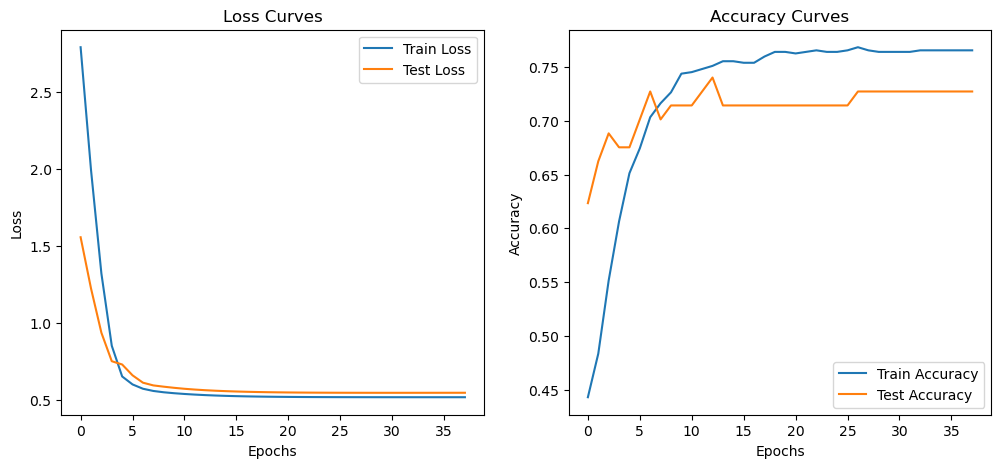

In [36]:
# Plot the training and test loss and accuracy curves for the final model
plt.figure(figsize=(12, 5))

# Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# Final evaluation of the model on the train set
train_loss, train_acc = model.evaluate(x_train_preprocessed, y_train)
print(f"\nFinal train Loss: {train_loss:.4f}, train Accuracy: {train_acc:.4f}")

# print classification report for the train model
y_pred = model.predict(x_train_preprocessed)
y_pred_rounded = np.round(y_pred)
print(classification_report(y_train, y_pred_rounded))

20/20 [==============================] - 0s 3ms/step - loss: 0.5244 - accuracy: 0.7704

Final train Loss: 0.5244, train Accuracy: 0.7704
20/20 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       400
           1       0.66      0.72      0.69       214

    accuracy                           0.77       614
   macro avg       0.75      0.76      0.75       614
weighted avg       0.78      0.77      0.77       614



In [34]:
# Final evaluation of the model on the test set
test_loss, test_acc = model.evaluate(x_test_preprocessed, y_test)
print(f"\nFinal Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# print classification report for the final test model
y_pred = model.predict(x_test_preprocessed)
y_pred_rounded = np.round(y_pred)
print(classification_report(y_test, y_pred_rounded))

3/3 [==============================] - 0s 0s/step - loss: 0.5480 - accuracy: 0.7403

Final Test Loss: 0.5480, Test Accuracy: 0.7403
3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        50
           1       0.61      0.70      0.66        27

    accuracy                           0.74        77
   macro avg       0.72      0.73      0.72        77
weighted avg       0.75      0.74      0.74        77



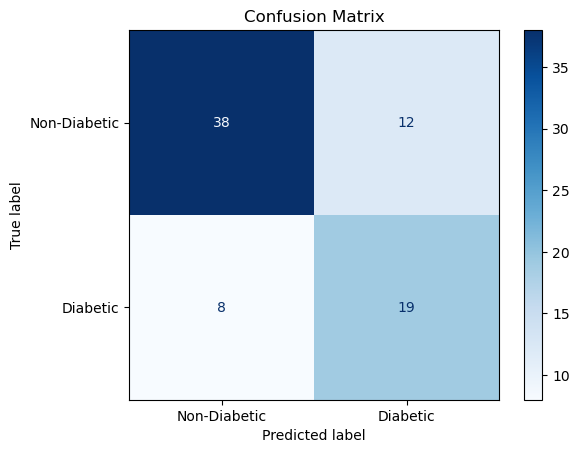

In [42]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rounded)

# Define custom labels for the classes
labels = ['Non-Diabetic', 'Diabetic']

# Plot confusion matrix with above specified labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


 Reference:
 
 [1] A. Géron, Hands-on machine learning with Scikit-Learn and TensorFlow concepts, tools, and techniques to build intelligent systems, 2nd ed. O’Reilly Media, Inc., 2019. 

 [2] I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. MIT Press, 2016.

 [3] “machine learning - Train/Test/Validation Set Splitting in Sklearn,” Data Science Stack Exchange. https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

 [4] GeeksforGeeks, “Perceptron class in Sklearn,” GeeksforGeeks, Oct. 12, 2023. https://www.geeksforgeeks.org/sklearn-perceptron/ (accessed Oct. 03, 2024).

 [5] GeeksforGeeks, “Sklearn | Model Hyperparameters Tuning,” GeeksforGeeks, Oct. 16, 2023. https://www.geeksforgeeks.org/sklearn-model-hyper-parameters-tuning/ (accessed Oct. 03, 2024).

 [6] GeeksforGeeks, “How to Plot Confusion Matrix with Labels in Sklearn?,” GeeksforGeeks, Jun. 17, 2024. https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/ (accessed Oct. 03, 2024).
‌
‌
‌
‌
‌